In [1]:
%matplotlib inline

In [2]:
import random
import time
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from skimage.segmentation import find_boundaries

In [3]:
def GWO(objf,lb,ub,dim,SearchAgents_no,Max_iter):
    
    # initialize alpha, beta, and delta_pos
    Alpha_pos=np.zeros(dim)
    Alpha_score=float("inf")
    
    Beta_pos=np.zeros(dim)
    Beta_score=float("inf")
    
    Delta_pos=np.zeros(dim)
    Delta_score=float("inf")

    if not isinstance(lb, list):
        lb = [lb] * dim
    if not isinstance(ub, list):
        ub = [ub] * dim
    
    #Initialize the positions of search agents
    Positions = np.zeros((SearchAgents_no, dim))
    for i in range(dim):
        Positions[:, i] = np.random.uniform(0,1, SearchAgents_no) * (ub[i] - lb[i]) + lb[i]
    
    Convergence_curve=np.zeros(Max_iter)

     # Loop counter
    print("GWO is optimizing  \""+objf.__name__+"\"")    

    # Main loop
    for l in range(0,Max_iter):
        for i in range(0,SearchAgents_no):
            
            # Return back the search agents that go beyond the boundaries of the search space
            for j in range(dim):
                Positions[i,j]=np.clip(Positions[i,j], lb[j], ub[j])

            # Calculate objective function for each search agent
            fitness=objf(Positions[i,:])
            
            # Update Alpha, Beta, and Delta
            if fitness<Alpha_score :
                Alpha_score=fitness; # Update alpha
                Alpha_pos=Positions[i,:].copy()
            
            
            if (fitness>Alpha_score and fitness<Beta_score ):
                Beta_score=fitness  # Update beta
                Beta_pos=Positions[i,:].copy()
            
            
            if (fitness>Alpha_score and fitness>Beta_score and fitness<Delta_score): 
                Delta_score=fitness # Update delta
                Delta_pos=Positions[i,:].copy()
        
        a=2-l*((2)/Max_iter); # a decreases linearly fron 2 to 0
        
        # Update the Position of search agents including omegas
        for i in range(0,SearchAgents_no):
            for j in range (0,dim):     
                           
                r1=random.random() # r1 is a random number in [0,1]
                r2=random.random() # r2 is a random number in [0,1]
                
                A1=2*a*r1-a; # Equation (3.3)
                C1=2*r2; # Equation (3.4)
                
                D_alpha=abs(C1*Alpha_pos[j]-Positions[i,j]); # Equation (3.5)-part 1
                X1=Alpha_pos[j]-A1*D_alpha; # Equation (3.6)-part 1
                           
                r1=random.random()
                r2=random.random()
                
                A2=2*a*r1-a; # Equation (3.3)
                C2=2*r2; # Equation (3.4)
                
                D_beta=abs(C2*Beta_pos[j]-Positions[i,j]); # Equation (3.5)-part 2
                X2=Beta_pos[j]-A2*D_beta; # Equation (3.6)-part 2       
                
                r1=random.random()
                r2=random.random() 
                
                A3=2*a*r1-a; # Equation (3.3)
                C3=2*r2; # Equation (3.4)
                
                D_delta=abs(C3*Delta_pos[j]-Positions[i,j]); # Equation (3.5)-part 3
                X3=Delta_pos[j]-A3*D_delta; # Equation (3.5)-part 3             
                
                Positions[i,j]=(X1+X2+X3)/3  # Equation (3.7)        
        Convergence_curve[l]=Alpha_score;

        #if (l%1==0):
               #print(['At iteration '+ str(l)+ ' the best fitness is '+ str(Alpha_score)]);
    
    print(Positions.shape)
    print("Alpha position=",Alpha_pos);
    print("Beta position=",Beta_pos);
    print("Delta position=",Delta_pos);
    return Alpha_pos,Beta_pos;

In [4]:
from flask import Flask, request, render_template
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


def load_image(image_path, color=True):
    if color:
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return image

def flatten_image(image):
    if len(image.shape) == 3:
        pixels = image.reshape(-1, 3)
    else:
        pixels = image.reshape(-1, 1)
    return pixels


def objective_function(centroids, pixels):
    labels = KMeans(n_clusters=len(centroids), init=centroids,
                    n_init=1).fit_predict(pixels)
    mse = np.mean((pixels - centroids[labels]) ** 2)
    return mse

def perform_gwo_optimization(pixels, num_centroids, num_wolves, max_iter):
    dim = pixels.shape[1] * num_centroids
    lb = 0
    ub = 255
    
    def objective(centroids):
        return objective_function(centroids.reshape(-1, pixels.shape[1]), pixels)
    
    alpha_pos, _ = GWO(objective, lb, ub, dim, num_wolves, max_iter)
    centroids = alpha_pos.reshape(-1, pixels.shape[1])
    return centroids

# def perform_image_segmentation(image_path, num_centroids, num_wolves, max_iter, color=True):
#     image = load_image(image_path, color)
#     pixels = flatten_image(image)
#     centroids = perform_gwo_optimization(pixels, num_centroids, num_wolves, max_iter)
#     labels = KMeans(n_clusters=num_centroids, init=centroids, n_init=1).fit_predict(pixels)
    
#     # Reshape labels to the original image shape
#     segmented_labels = labels.reshape(image.shape[:2])

#     # Find boundaries of the segments
#     boundaries = find_boundaries(segmented_labels, mode='thick')

#     # Create an image to display the boundaries
#     boundary_image = image.copy()
#     boundary_image[boundaries] = [255, 0, 0]  # Red color for boundaries

#     # Display the original and boundary images
#     plt.figure(figsize=(10, 5))

#     plt.subplot(1, 2, 1)
#     plt.imshow(image)
#     plt.title('Original Image')

#     plt.subplot(1, 2, 2)
#     plt.imshow(boundary_image)
#     plt.title('Segmented Image with Boundaries')

#     plt.show()
def perform_image_segmentation(image_path, num_centroids, num_wolves, max_iter, color=True):
    image = load_image(image_path, color)
    pixels = flatten_image(image)
    centroids = perform_gwo_optimization(pixels, num_centroids, num_wolves, max_iter)
    labels = KMeans(n_clusters=num_centroids, init=centroids, n_init=1).fit_predict(pixels)
    
    if len(image.shape) == 3:
        segmented_image = centroids[labels].reshape(image.shape)
        segmented_image = cv2.cvtColor(
            segmented_image.astype(np.uint8), cv2.COLOR_RGB2BGR)
    else:
        segmented_image = centroids[labels].reshape(image.shape)
        segmented_image = segmented_image.astype(np.uint8)

    # Display the original and segmented images
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(segmented_image)
    plt.title('Segmented Image')

    plt.show()



GWO is optimizing  "objective"
(144, 36)
Alpha position= [ 88.30368861  47.28449056  31.18272414 166.18871982 167.57039775
 110.63246181 160.58705882  51.45267412 117.16821502  30.67697572
  12.64792989   6.53482974 202.08878768 197.05674524 186.22058483
 228.4345413  245.87532998 228.95262569 149.9112609   36.62088171
  81.95749041 170.776139   147.77398684 149.98845874 171.57443782
 203.18414006 148.99421333 229.47400791 213.36785724 223.24723699
  71.81137975  33.03286588 112.9988259   24.03771822 118.47673731
  90.93840976]
Beta position= [ 83.73972635  35.78968504  29.51055427 163.68322992 159.77698653
 125.15959658 156.64728842  54.61507472 117.59818144  27.52781908
  12.89692177   5.29132695 201.76518785 195.45102459 194.57639441
 240.46694827 254.49259477 224.43422245 138.58503585  34.22555312
  87.44896706 183.9615394  150.10577054 153.21664886 202.50871937
 207.67463172 138.26734648 208.82339746 204.57973075 214.49805981
  73.64252922  32.6804238  120.61888111  22.62356567 12

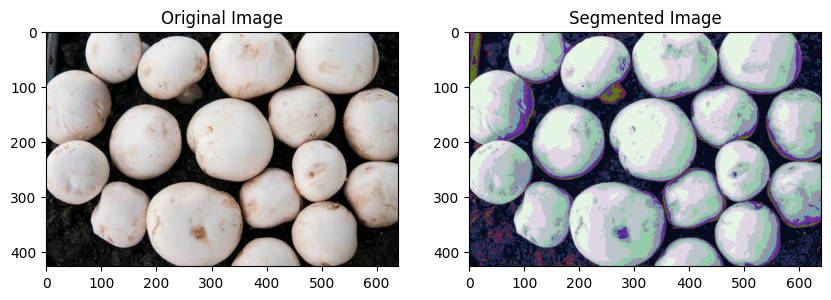

GWO is optimizing  "objective"
(169, 39)
Alpha position= [233.69669417 212.71752367 223.27702905 196.60505106 185.12062539
 160.96767085 115.17851711  93.59879877  37.11998458 244.84514528
 218.33168089 226.00558159  90.48362647 111.5676852   82.4669986
  73.26237192  60.33701824  55.11662874 176.94157303 136.96781828
 123.61346562   3.11311009 144.31219318 101.0823593   30.13506619
  28.55844691  41.85689655  10.9191622   16.20217231  28.78399688
 198.39063011 164.69870914 139.04163534 202.94828863 229.84498825
 194.53394799 197.24394609 186.60423636 180.46632124]
Beta position= [219.88313201 222.62054379 210.78243536 187.95949439 186.49980056
 146.5087357   91.42283954 103.98088916  39.85255656 215.0075796
 251.92053754 219.13070798 104.59112128  89.94397977  85.00912803
  67.66007184  54.23047491  57.00226409 158.95439174 156.90980095
 142.2645429    2.83593024 135.88680226  99.90208574  29.52554433
  27.33644629  40.24444579  11.65518958  16.53384525  30.77102513
 185.7344646  186.

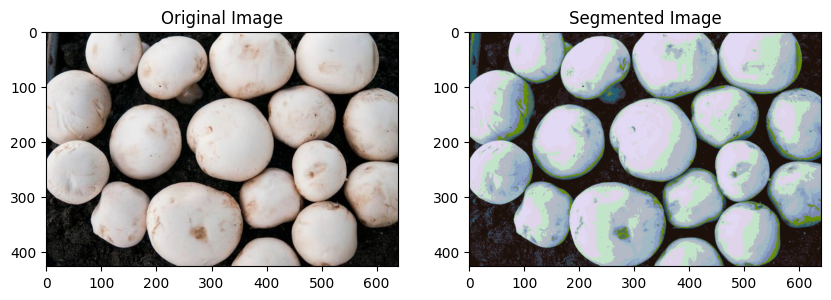

GWO is optimizing  "objective"
(256, 42)
Alpha position= [ 91.11484086  92.78703367  13.37930474 241.26850633 238.57008337
 231.42089145 203.15551254 195.74833165 227.47310942 175.59798813
 148.42741388 138.74558076 156.62922384 152.59385839 145.0905342
 212.87763129 192.63375353 204.40954144 174.57794519 111.38942916
  95.26722684 238.21189389 226.26859566 200.12495588 205.43052184
  32.3447957   99.61964998 185.95598061 157.39129238 148.03983782
  61.01149206  66.04479202  73.00251893  22.89106421   5.60484221
  25.43969644  35.18968476  49.2011805   29.55521777  31.41021342
   2.07587946  39.71949013]
Beta position= [ 90.3748049   98.19134796  13.34363524 245.1188744  239.25846126
 247.80670658 209.55068576 190.67703718 192.92459483 156.07664815
 145.33173398 143.05220654 150.88119845 156.74932478 170.79105358
 181.2594467  181.93840887 181.89578788 185.73940013 114.87115879
  96.46213818 208.24742491 197.48231946 194.61019788 179.38569195
  30.11513883  81.50775102 178.78629732 183

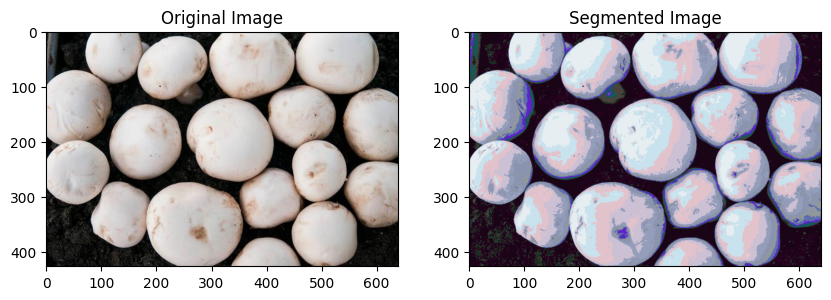

Execution time with 12 centroids and 144 wolves: 533.31 seconds
Execution time with 13 centroids and 169 wolves: 577.78 seconds
Execution time with 14 centroids and 256 wolves: 982.07 seconds


In [5]:
import time

times = []
parameters = [
    {'num_centroids': 12, 'num_wolves': 144, 'max_iter': 10},
    {'num_centroids': 13, 'num_wolves': 169, 'max_iter': 10},
    {'num_centroids': 14, 'num_wolves': 256, 'max_iter': 10}
]

for params in parameters:
    start_time = time.time()
    perform_image_segmentation(image_path='static\mushrooms0.jpg', **params, color=True)
    elapsed_time = time.time() - start_time
    times.append(elapsed_time)

# Print the recorded times
for i, t in enumerate(times):
    print(f"Execution time with {parameters[i]['num_centroids']} centroids and {parameters[i]['num_wolves']} wolves: {t:.2f} seconds")

GWO is optimizing  "objective"
(4, 6)
Alpha position= [ 63.50777282  65.43560766 104.86149927 167.45288134 214.75358984
 170.23549859]
Beta position= [ 60.68363178  62.86655429 120.09975247 167.71400394 214.25588698
 191.94450332]
Delta position= [ 67.93399092  70.38596613 116.58550323 158.26222486 212.16279327
 178.01381372]


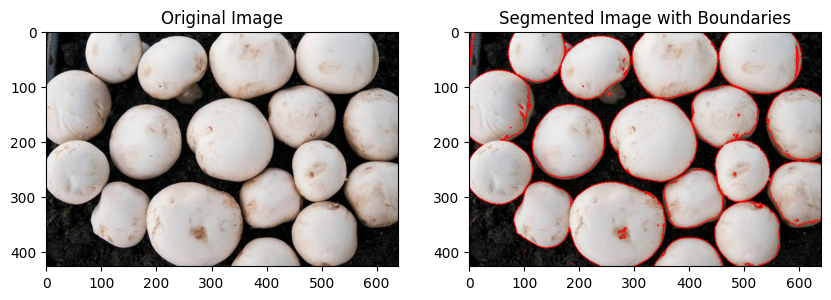

GWO is optimizing  "objective"
(16, 12)
Alpha position= [194.5426798  158.71364843 153.22942627 214.70691274 198.91746955
 222.13801412  34.78944822  56.64676779  53.3430974  128.5001161
 133.09099414 117.47669349]
Beta position= [197.38544953 188.62318506 150.13084832 216.64390176 193.20651107
 215.08495795  42.90416252  62.44956119  47.26859782 117.52033921
 118.36882148 105.76045275]
Delta position= [187.77831719 189.25884068 129.69518382 242.0514794  198.32040591
 226.33090938  35.29438466  53.29286655  49.11141512 115.61593902
 110.36277437 117.11393376]


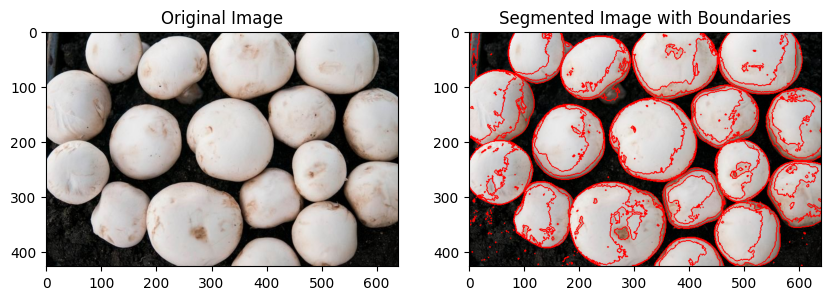

GWO is optimizing  "objective"
(25, 15)
Alpha position= [213.25106095 204.87152678 222.49551132  39.58951955   3.21856851
  29.03236522 176.82612373 200.09266926 190.53174098  41.24687243
  56.86019497 110.59168878 187.97883778 123.32746206 122.21867557]
Beta position= [202.79282434 210.92482722 231.58460518  40.26195798   3.27822111
  31.98207826 186.24271499 194.93663404 190.34932406  38.26696089
  60.66550459  93.50953532 157.80015676 111.53255507 169.88271119]
Delta position= [203.66210076 233.68241745 192.55062819  40.42965113   3.74801665
  33.68114953 202.31251776 188.47734863 173.60602042  46.07527531
  68.38682898 101.55722672 174.9309369  103.15525923 150.68314787]


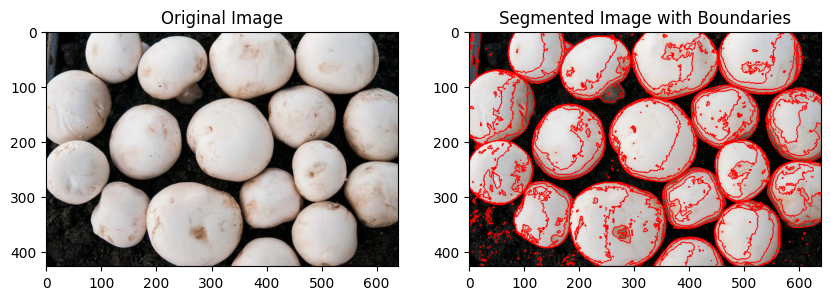

In [12]:

perform_image_segmentation(image_path='static\mushrooms0.jpg', num_centroids=2, num_wolves=4, max_iter=10,color=True)
perform_image_segmentation(image_path='static\mushrooms0.jpg', num_centroids=4, num_wolves=16, max_iter=10,color=True)
perform_image_segmentation(image_path='static\mushrooms0.jpg', num_centroids=5, num_wolves=25, max_iter=10,color=True)